_Notes_

This notebook comes from http://datashader.org/topics/census.html

- The first two code cells have minor modifications
- The last part was removed

First run these commands:

```
conda install -n python3 bokeh dask datashader fastparquet numba python-snappy

wget http://s3.amazonaws.com/datashader-data/census2010.parq.zip
    
unzip census2010.parq.zip
```

In [3]:
!wget http://s3.amazonaws.com/datashader-data/census2010.parq.zip


--2019-02-25 19:03:52--  http://s3.amazonaws.com/datashader-data/census2010.parq.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.98.187
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.98.187|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1442333063 (1.3G) [application/zip]
Saving to: ‘census2010.parq.zip’

census2010.parq.zip 100%[===================>]   1.34G  95.4MB/s    in 14s     

2019-02-25 19:04:06 (95.8 MB/s) - ‘census2010.parq.zip’ saved [1442333063/1442333063]



In [4]:
!unzip census2010.parq.zip

Archive:  census2010.parq.zip
   creating: census2010.parq/
  inflating: census2010.parq/part.33.parquet  
  inflating: census2010.parq/part.23.parquet  
  inflating: census2010.parq/_common_metadata  
  inflating: census2010.parq/part.15.parquet  
  inflating: census2010.parq/part.4.parquet  
  inflating: census2010.parq/part.14.parquet  
  inflating: census2010.parq/part.5.parquet  
  inflating: census2010.parq/part.22.parquet  
  inflating: census2010.parq/part.32.parquet  
  inflating: census2010.parq/part.16.parquet  
  inflating: census2010.parq/part.29.parquet  
  inflating: census2010.parq/part.7.parquet  
  inflating: census2010.parq/part.30.parquet  
  inflating: census2010.parq/part.20.parquet  
  inflating: census2010.parq/part.21.parquet  
  inflating: census2010.parq/part.31.parquet  
  inflating: census2010.parq/part.17.parquet  
  inflating: census2010.parq/part.28.parquet  
  inflating: census2010.parq/part.6.parquet  
  inflating: census2010.parq/_metadata  
  inflati

## 2010 US Census data

The 2010 Census collected a variety of demographic information for all the more than 300 million people in the USA.  Here we'll focus on the subset of the data selected by the Cooper Center, who produced a [map of the population density and the racial makeup of the USA](http://www.coopercenter.org/demographics/Racial-Dot-Map).  Each dot in this map corresponds to a specific person counted in the census, located approximately at their residence. (To protect privacy, the precise locations have been randomized at the census block level, so that the racial category can only be determined to within a rough geographic precision.) The Cooper Center website delivers pre-rendered tiles, which are fast to view but limited to the specific plotting choices they made.  Here we will show how to run novel analyses focusing on whatever aspects of the data that you select yourself, rendered dynamically as requested using the [Datashader](https://github.com/bokeh/datashader) library.

**NOTE:** This dataset is also explorable through the Datashader example dashboard. From inside the datashader examples directory, run: `DS_DATASET=census panel serve --show dashboard.ipynb`


### Load data and set up

The census data has been saved in a [Parquet](https://parquet.apache.org)-format file, which can be loaded into a columnar data structure like a [Pandas](https://pandas.pydata.org) or [Dask](http://dask.pydata.org) dataframe. 

To load the dataframe, you'll need to install `fastparquet` and `python-snappy`.

In [5]:
import datashader as ds, datashader.transfer_functions as tf, numpy as np

In [6]:
%%time
import dask.dataframe as dd
df = dd.io.parquet.read_parquet('census2010.parq')
df = df.persist()

CPU times: user 26.9 s, sys: 6.35 s, total: 33.2 s
Wall time: 5.65 s


Here we call ``.persist()`` to use Dask's fast in-core operations, but if you have less than 16GB of RAM, you can omit that line to use Dask's support for out-of-core (larger than memory) operation. Working out of core will be much slower, but should work even on small machines.

In [7]:
df.head()

,easting,northing,race
0,-12418767.0,3697425.00,h
1,-12418512.0,3697143.50,h
2,-12418245.0,3697584.50,h
3,-12417703.0,3697636.75,w
4,-12418120.0,3697129.25,h


There are 306675004 rows in this dataframe (one per person counted in the census), each with a location in Web Mercator format and a race encoded as a single character (where 'w' is white, 'b' is black, 'a' is Asian, 'h' is Hispanic, and 'o' is other (typically Native American)). (Try ``len(df)`` to see the size, if you want to check, though that always forces the dataset to be loaded so it's skipped here.)

Let's define some geographic ranges to look at later, and also a default plot size.  Feel free to increase `plot_width` to 2000 or more if you have a very large monitor or want to save big files to disk, which shouldn't *greatly* affect the processing time or memory requirements.  

In [8]:
USA           = ((-124.72,  -66.95), (23.55, 50.06))
LakeMichigan  = (( -91.68,  -83.97), (40.75, 44.08))
Chicago       = (( -88.29,  -87.30), (41.57, 42.00))
Chinatown     = (( -87.67,  -87.63), (41.84, 41.86))
NewYorkCity   = (( -74.39,  -73.44), (40.51, 40.91))
LosAngeles    = ((-118.53, -117.81), (33.63, 33.96))
Houston       = (( -96.05,  -94.68), (29.45, 30.11))
Austin        = (( -97.91,  -97.52), (30.17, 30.37))
NewOrleans    = (( -90.37,  -89.89), (29.82, 30.05))
Atlanta       = (( -84.88,  -84.04), (33.45, 33.84))

from datashader.utils import lnglat_to_meters as webm
x_range,y_range = [list(r) for r in webm(*USA)]

plot_width  = int(900)
plot_height = int(plot_width*7.0/12)

Let's also choose a background color for our results.  A black background makes bright colors more vivid, and works well when later adding relatively dark satellite image backgrounds, but white backgrounds (`background=None`) are good for examining the weakest patterns, and work well when overlaying on maps that use light colors.  Try it both ways and decide for yourself!

In [9]:
background = "black"

We'll also need some utility functions and colormaps, and to make the page as big as possible:

In [10]:
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9
from IPython.core.display import HTML, display

export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

display(HTML("<style>.container { width:100% !important; }</style>"))

### Population density

For our first examples, let's ignore the race data for now, focusing on population density alone (as for the nyc_taxi.ipynb example).  We'll first aggregate all the points from the continental USA into a grid containing the population density per pixel:

In [11]:
%%time
cvs = ds.Canvas(plot_width, plot_height, *webm(*USA))
agg = cvs.points(df, 'easting', 'northing')

CPU times: user 3.58 s, sys: 5.35 ms, total: 3.59 s
Wall time: 684 ms


Computing this aggregate grid will take some CPU power (1 second on a MacBook Pro), because datashader has to iterate through the entire dataset, with hundreds of millions of points.  Once the `agg` array has been computed, subsequent processing will now be nearly instantaneous, because there are far fewer pixels on a screen than points in the original database.

If we now plot the aggregate grid linearly, we can clearly see...

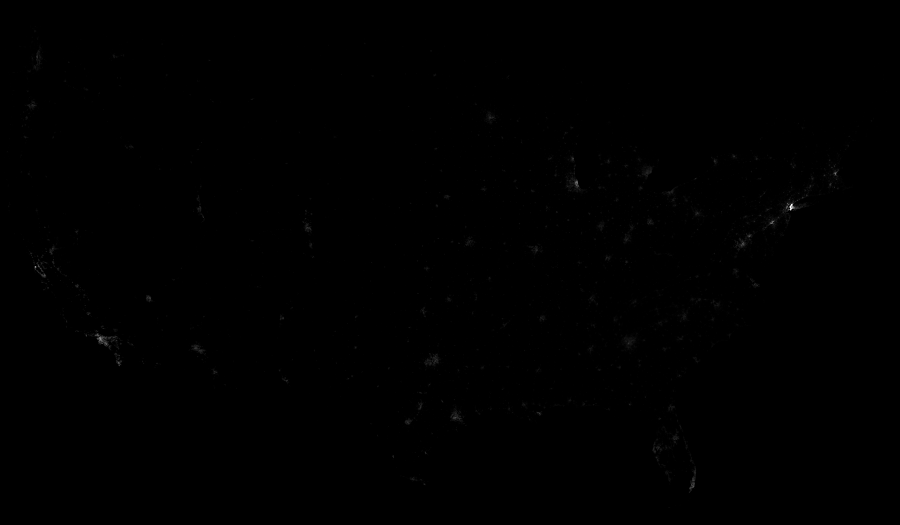

In [12]:
export(tf.shade(agg, cmap = cm(Greys9), how='linear'),"census_gray_linear")

...almost nothing.  If you know what to look for, you can see hotspots (high population densities) in New York City, Los Angeles, Chicago, and a few other places.  More hotspots can dimly be seen when using a white background than with a black, on most monitors, though they are very dim either way. In any case, for feeding 300 million points in, we're getting almost nothing back in terms of visualization.

The first thing we can do is to prevent undersampling (see plotting_pitfalls.ipynb).  In the plot above, there is no way to distinguish between pixels that are part of the background, and those that have low but nonzero counts; both are mapped to black or nearly black on a linear scale.  Instead, let's map all values that are not background to a dimly visible gray, leaving the highest-density values at white.  I.e., let's discard the first 25% of the gray colormap, and linearly interpolate the population densities over the remaining range:

In [ ]:
export(tf.shade(agg, cmap = cm(Greys9,0.25), how='linear'),"census_gray_linear")

The above plot reveals at least that data has been measured only within the political boundaries of the continental United States, and also that many areas in the West are so poorly populated that many pixels contained not even a single person.  (In datashader images, the background color is shown for pixels that have no data at all, using the alpha channel of a PNG image, while the colormap range is shown for pixels that do have data.)  Some additional population centers are now visible, at least on some monitors. But mainly what the above plot indicates is that population in the USA is extremely non-uniformly distributed, with hotspots in a few regions, and nearly all other pixels having much, much lower (but nonzero) values. Again, that's not much information to be getting out out of 300 million datapoints!

The problem is that of the available intensity scale in this gray colormap, nearly all pixels are colored the same low-end gray value, with only a few urban areas using any other colors.  Thus this version of the map conveys very little information as well.  Because the data are clearly distributed so non-uniformly, let's instead try a nonlinear mapping from population counts into the colormap.  A logarithmic mapping is often a good choice:

In [ ]:
export(tf.shade(agg, cmap = cm(Greys9,0.2), how='log'),"census_gray_log")

Suddenly, we can see an amazing amount of structure!  There are clearly meaningful patterns at nearly every location, ranging from the geographic variations in the mountainous West, to the densely spaced urban centers in New England, and the many towns stretched out along roadsides in the midwest (especially those leading to Denver, the hot spot towards the right of the Rocky Mountains).  

Clearly, we can now see much more of what's going on in this dataset, thanks to the logarithmic mapping.  Worryingly, though, the choice of `'log'` was purely arbitrary, basically just a hunch based on how typical datasets behave.  One could easily imagine that other nonlinear functions would show other interesting patterns, or that different functions would be needed for different datasets.  

Instead of blindly searching through the space of all such functions, we can step back and notice that the main effect of the log transform has been to reveal *local* patterns at all population densities -- small towns show up clearly even if they are just slightly more dense than their immediate, rural neighbors, yet large cities with high population density also show up well against the surrounding suburban regions, even if those regions are more dense than the small towns on an absolute scale.

With this idea of showing relative differences across a large range of data values in mind, let's try the image-processing technique called histogram equalization. I.e., given a set of raw counts, map these into a range for display such that every available color on the screen represents about the same number of samples in the original dataset.  The result is similar to that from the log transform, but is now non-parametric -- it will equalize any linearly or nonlinearly distributed integer data, regardless of the distribution:

In [ ]:
export(tf.shade(agg, cmap = cm(Greys9,0.2), how='eq_hist'),"census_gray_eq_hist")

(Histogram equalization also works for non-integer data, but in that case it will use a finite set of bins to divide the interval between the minimum and maximum values, and will thus not be able to normalize the histogram perfectly for highly non-uniform distributions.)  Effectively, this transformation converts the data from raw magnitudes, which can easily span a much greater range than the dynamic range visible to the eye, to a rank-order or percentile representation, which reveals density differences at all ranges but obscures the absolute magnitudes that were used to compute the ordering. In this representation, you can clearly see the effects of geography (rivers, coastlines, and mountains) on the population density, as well as history (denser near the longest-populated areas), and even infrastructure (with many small towns located at crossroads).

Given the very different results from the different types of plot, a good practice when visualizing any dataset with datashader is to look at both the linear and the histogram-equalized versions of the data; the linear version preserves the magnitudes, but obscures the distribution, while the histogram-equalized version reveals the distribution while preserving only the order of the magnitudes, not their actual values.  If both plots are similar, then the data is distributed nearly uniformly across the interval.  But much more commonly, the distribution will be highly nonlinear, and the linear plot will reveal only the envelope of the data, i.e., the lowest and the highest values.  In such cases, the histogram-equalized plot will reveal much more of the structure of the data, because it maps the local patterns in the data into perceptible color differences on the screen.

Because we are only plotting a single dimension, we can use the colors of the display to effectively reach a higher dynamic range, mapping ranges of data values into different color ranges. When doing so, it is crucial to use a perceptually uniform colormap (see [this paper](https://arxiv.org/pdf/1509.03700v1.pdf) for more details). Here we'll use the "fire" colormap from the [colorcet](https://github.com/bokeh/colorcet) package:

In [ ]:
from colorcet import fire
export(tf.shade(agg, cmap = cm(fire,0.2), how='eq_hist'),"census_ds_fire_eq_hist")

This should reveal even more of the detail than the gray colormaps above.  

You can also import colormaps directly from `matplotlib.cm` or `bokeh.palettes`, but only a few of those will be perceptually uniform.  For instance, matplotlib's "hot" colormap is similar to colorcet's "fire", but reveals far less of the detail available in this data because it has long stretches of perceptually equivalent colors:

In [ ]:
from matplotlib.cm import hot
export(tf.shade(agg, cmap = hot, how='eq_hist'),"census_ds_mhot_eq_hist")

Also note that the ``cm()`` function used here that lets us switch backgrounds and prevent undersampling only supports Bokeh palettes (either provided by Bokeh or from cetcolors), though we do provide Bokeh-palette versions of matplotlib's perceptually uniform `viridis` and `inferno` colormaps from within datashader:

In [ ]:
from datashader.colors import viridis
export(tf.shade(agg, cmap=cm(viridis), how='eq_hist'),"census_viridis_eq_hist")

For plotting magnitudes of this type, it should be safe to use any of the "linear" colormaps from the [colorcet](https://github.com/bokeh/colorcet) package, depending on your preference.

Colormaps can also be used to address very specific questions about the data itself.  For instance, after histogram equalization, data should be uniformly distributed across the visible colormap.  Thus if we want to highlight e.g. the top 1% of pixels, by population density, we can use a colormap divided into 100 ranges, and just change the top one to a different color:

In [ ]:
grays2 = cm([(i,i,i) for i in np.linspace(0,255,99)])
grays2 += ["red"]
export(tf.shade(agg, cmap = grays2, how='eq_hist'),"census_gray_redhot1_eq_hist")

The above plot now conveys nearly all the information available in the linear plot, i.e. that only a few pixels have the very highest population densities, while also conveying the structure of the data at all population density ranges via histogram equalization.  And in no case was any parameter value chosen based on the data itself, just on the question we wanted to ask about the data, which is crucial for posing and answering questions objectively using visualizations.

### Categorical data (race)

Since we've got the racial category for every pixel, we can use color to indicate the category value, instead of just extending dynamic range or highlighting percentiles as above.  To do this, we first need to set up a color key for each category label, with different color keys as appropriate to make colors that stand out against the background:

In [ ]:
if background == "black":
      color_key = {'w':'aqua', 'b':'lime',  'a':'red', 'h':'fuchsia', 'o':'yellow' }
else: color_key = {'w':'blue', 'b':'green', 'a':'red', 'h':'orange',  'o':'saddlebrown'}

We can now aggregate the counts *per race* into grids, using `ds.count_cat`, instead of just a single grid with the total counts (via the default aggregate reducer `ds.count`), and then generate an image by colorizing each pixel using the aggregate information from each category for that pixel's location:

In [ ]:
def create_image(longitude_range, latitude_range, w=plot_width, h=plot_height):
    x_range,y_range=webm(longitude_range,latitude_range)
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(df, 'easting', 'northing', ds.count_cat('race'))
    img = tf.shade(agg, color_key=color_key, how='eq_hist')
    return img

The result shows that the USA is overwhelmingly white, apart from some predominantly Hispanic regions along the Southern border, some regions with high densities of blacks in the Southeast, and a few isolated areas of category "Other" in the West (primarily Native American reservation areas).

In [ ]:
%%time
export(create_image(*USA),"Zoom 0 - USA")

Interestingly, the racial makeup has some sharp boundaries around urban centers, as we can see if we zoom in (which should be faster than the full USA using this SpatialPointsFrame):

In [ ]:
%%time
export(create_image(*LakeMichigan),"Zoom 1 - Lake Michigan")

With sufficient zoom, it becomes clear that Chicago (like most large US cities) has both a wide diversity of racial groups, and profound geographic segregation:

In [ ]:
%%time
export(create_image(*Chicago),"Zoom 2 - Chicago")

Eventually, we can zoom in far enough to see individual datapoints.  Here we can see that the Chinatown region of Chicago has, as expected, very high numbers of Asian residents, and that other nearby regions (separated by geographic features like rivers, railroads and highways) have other races, varying in how uniformly segregated they are:

In [ ]:
%%time
export(tf.spread(create_image(*Chinatown),px=plot_width//400),"Zoom 3 - Chinatown")

Note that here we've used the `tf.spread` function to enlarge each point to cover multiple pixels so that each point is clearly visible, which adds a bit to the computation time. 

### Other cities, for comparison

Different US cities have very different racial makeup, but they all appear highly segregated:

In [ ]:
export(create_image(*NewYorkCity),"NYC")

In [ ]:
export(create_image(*LosAngeles),"LosAngeles")

In [ ]:
export(create_image(*Houston),"Houston")

In [ ]:
export(create_image(*Atlanta),"Atlanta")

In [ ]:
export(create_image(*NewOrleans),"NewOrleans")

In [ ]:
export(create_image(*Austin),"Austin")

### Analyzing racial data through visualization

In addition to simply visualizing categorical data, we can break those categories down to ask specific questions.  For instance, if we switch back to the full USA and then select only the black population, we can see that blacks predominantly reside in urban areas except in the South and the East Coast:

In [ ]:
cvs = ds.Canvas(plot_width=plot_width, plot_height=plot_height)
aggc = cvs.points(df, 'easting', 'northing', ds.count_cat('race'))

export(tf.shade(aggc.sel(race='b'), cmap=cm(Greys9,0.25), how='eq_hist'),"USA blacks")

(Compare to "census_gray_eq_hist" above.)

Or we can show only those pixels where there is at least one resident from each of the racial categories white, black, Asian, and Hispanic, which mainly highlights urban areas (compare to "Zoom 0 - USA" above):

In [ ]:
agg2 = aggc.where((aggc.sel(race=['w', 'b', 'a', 'h']) > 0).all(dim='race')).fillna(0)
export(tf.shade(agg2, color_key=color_key, how='eq_hist'),"USA all")

In the above plot, the colors still show the racial makeup of each pixel, but the pixels have been filtered so that only those with at least one datapoint from every race are shown.

Or we can look at all pixels where there are more black than white datapoints, which highlights predominantly black neighborhoods of large urban areas across most of the USA, but some rural areas and small towns in the South:

In [ ]:
export(tf.shade(aggc.where(aggc.sel(race='w') < aggc.sel(race='b')).fillna(0), color_key=color_key, how='eq_hist'),"more_blacks")

Here the colors still show the predominant race in that pixel, which is black for many of these, but in Southern California it looks like there are several large neighborhoods where blacks outnumber whites but both are outnumbered by Hispanics.

In any case, the thing to do here is to try out your own hypotheses and questions, whether for the USA or for your own region. The aggregate array is just an ordinary xarray multidimensional array, so you can see the [xarray documentation](http://xarray.pydata.org) for how to select and transform that data.  E.g. you can try posing questions that are independent of the number of datapoints in each pixel, since that varies so much geographically, by normalizing the aggregated data in various ways. Now that the data's been aggregated but not yet rendered to the screen, there is an infinite range of queries you can pose!